In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint


In [7]:
df = pd.read_csv('./sales_data.csv')

In [8]:
df.head(10)

,Date,Company,Type of Client,Type of Location,Location,Rating,Amount,Salesman
0,01-04-2024,PHOTON POCKET ENERGIES,Dealer,Industrial Complex,Sahibabad,1250 kVA,981288.0,A
1,04-04-2024,VK GLOBAL DIGITAL,Regular,Industrial Complex,Faridabad,380 kVA,430700.0,B
2,06-04-2024,OVN ENGINEERS,Dealer,Corporate Office,Gurgaon,380 kVA,340000.0,A
3,06-04-2024,OVN ENGINEERS,Dealer,Corporate Office,Gurgaon,125 kVA,244100.0,A
4,08-04-2024,GANDHARVA SOCIETY,Regular,Residential,Greater Noida,320 kVA,472708.0,C
5,10-04-2024,PASCOS,Regular,Corporate Office,South Delhi,380 kVA,370000.0,B
6,11-04-2024,GEN TECH ENGINEERS,Dealer,Corporate Office,Noida,180 kVA,283200.0,A
7,13-04-2024,OLIVE COUNTRY,Regular,Residential,Ghaziabad,600 kVA,699150.0,C
8,13-04-2024,OLIVE COUNTRY,Regular,Residential,Ghaziabad,600 kVA,699150.0,C
9,17-04-2024,DM REALTY DEVELOPER,Regular,Residential,Faridabad,1010 kVA,590000.0,A


In [9]:
print(df.columns)

Index(['Date', 'Company', 'Type of Client', 'Type of Location', 'Location',
       'Rating', 'Amount', 'Salesman'],
      dtype='object')


In [16]:
client_type = df['Type of Client'].astype('category')
location_type = df['Type of Location'].astype('category')
salesman = df['Salesman'].astype('category')
company = df['Company'].astype('category')
location = df['Location'].astype('category')
rating = df['Rating'].value_counts().astype('category')
amount = pd.to_numeric(df['Amount'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce') 
month = df['Date'].dt.month

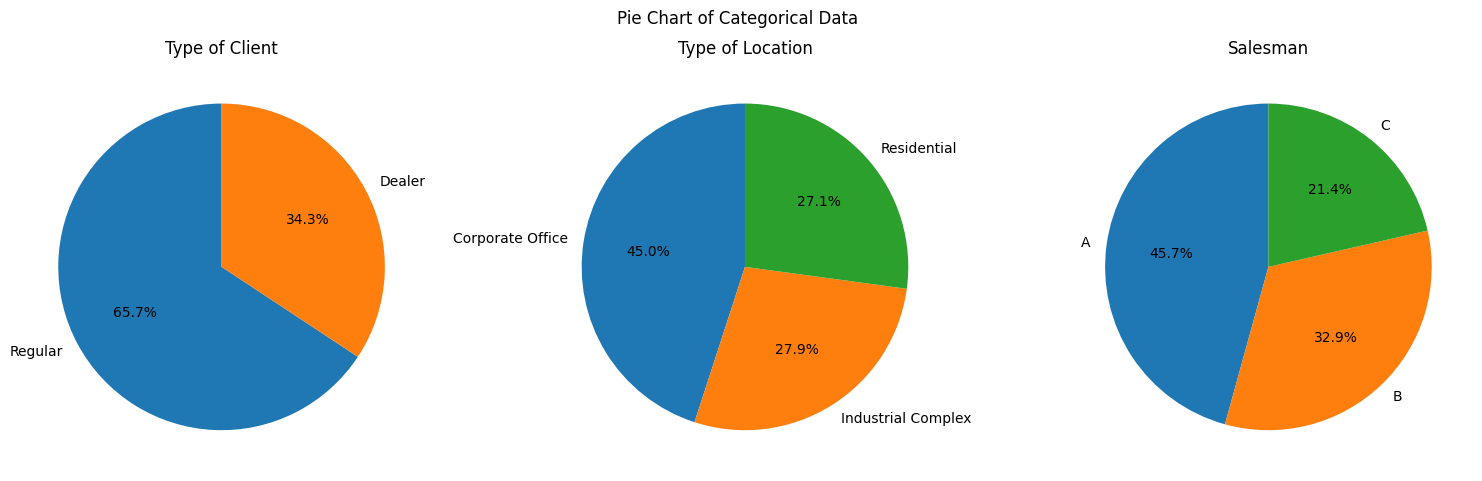

In [17]:
#Pie Chart for Categorical Data
client_type_count = df['Type of Client'].value_counts()
location_type_count = df['Type of Location'].value_counts()
salesman_count = df['Salesman'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].pie(client_type_count, labels=client_type_count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Type of Client')

axs[1].pie(location_type_count, labels=location_type_count.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Type of Location')

axs[2].pie(salesman_count, labels=salesman_count.index, autopct='%1.1f%%',startangle=90)
axs[2].set_title('Salesman')

fig.suptitle('Pie Chart of Categorical Data')
plt.tight_layout()
plt.show()

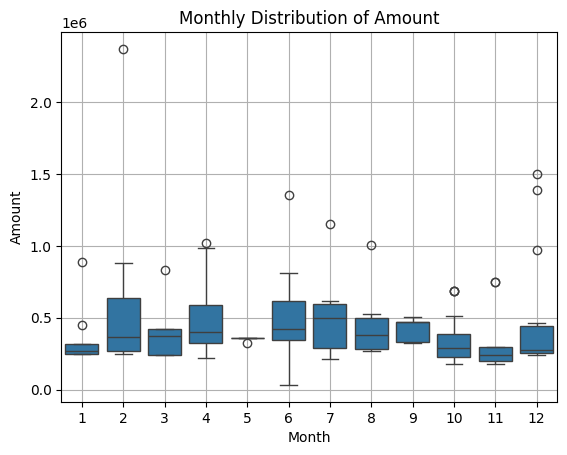

In [18]:

sns.boxplot(x=month, y=amount, data=df)
plt.title('Monthly Distribution of Amount')
plt.ylabel('Amount')
plt.xlabel('Month')
plt.grid(True)
plt.show()

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
client_location_stats = df.groupby('Type of Location')['Amount'].mean()
client_location_stats.plot(kind='bar', ax=axes[0], title='Average Sales by Location Type', color='skyblue')

axes[0].set_xlabel('Type of Location')
axes[0].set_ylabel('Average Sales (INR)')
client_type_stats = df.groupby('Type of Client')['Amount'].mean()
client_type_stats.plot(kind='bar', ax=axes[1], title='Average Sales by Client Type', color='red')

axes[1].set_xlabel('Type of Client')
axes[1].set_ylabel('Average Sales (INR)')
salesman_stats = df.groupby('Salesman')['Amount'].mean()
salesman_stats.plot(kind='bar', ax=axes[2], title='Average Sales by Salesman', color='green'# Group by Salesman and Type of Location, then count total and successful sales
grouped_success = df.groupby(['Salesman', 'Type of Location'])['Success'].agg(['count', 'sum'])

# Calculate success rate
grouped_success['Success Rate'] = grouped_success['sum'] / grouped_success['count']

# Reset index to flatten the DataFrame
grouped_success = grouped_success.reset_index()

# Create a pivot table to compare success rates across locations for each salesman
pivot_table = grouped_success.pivot(
    index='Salesman',
    columns='Type of Location',
    values='Success Rate'
)
)
axes[2].set_xlabel('Salesman')
axes[2].set_ylabel('Average Sales (INR)')
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4247446156.py, line 13)

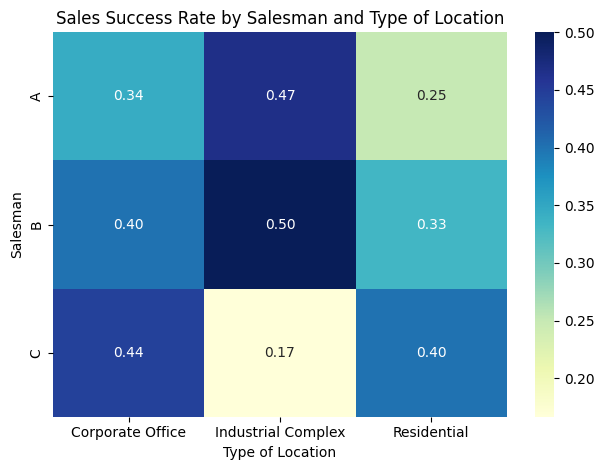

In [37]:
grouped_success = df.groupby(['Salesman', 'Type of Location'])['Success'].agg(['count', 'sum'])
grouped_success['Success Rate'] = grouped_success['sum'] / grouped_success['count']
grouped_success = grouped_success.reset_index()
pivot_table = grouped_success.pivot(index='Salesman', columns='Type of Location', values='Success Rate')

#plt.figure()
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Sales Success Rate by Salesman and Type of Location')
plt.ylabel('Salesman')
plt.xlabel('Type of Location')
plt.tight_layout()
plt.show()

In [40]:
grouped_success.sort_values('Success Rate', ascending=False)
overall_success_rate = df['Success'].mean()
print(f"Overall success rate: {overall_success_rate:.2f}")


Overall success rate: 0.38


In [41]:
# Convert 'Date' column to datetime and extract Month/Year
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Extract numeric part from Rating (e.g., "125kVA" -> 125.0)
df['Rating_kVA'] = df['Rating'].str.extract(r'(\d+\.?\d*)').astype(float)

# Calculate average amount by Rating
rating_avg = df.groupby('Rating')['Amount'].mean()
df['Rating_Avg_Amount'] = df['Rating'].map(rating_avg)

# Define Success as sales amount close to 10% or more of the median for that Rating
tolerance = 0.10  # 10% tolerance
rating_median = df.groupby('Rating')['Amount'].transform('median')
threshold = rating_median * (1 - tolerance)
df['Success'] = (df['Amount'] >= threshold).astype(int)

In [21]:
# Create new feature: Amount per kVA
df['Amount_per_kVA'] = df['Amount'] / df['Rating_kVA']

# Binary flag if client is a Dealer
df['Is_Dealer'] = (df['Type of Client'] == 'Dealer').astype(int)

# Binary flag for end of financial quarters (March, June, Sep, Dec)
df['Is_Quarter_End'] = df['Month'].isin([3, 6, 9, 12]).astype(int)

# Ratio of this sale to average sale in same location
location_avg = df.groupby('Location')['Amount'].transform('mean')
df['Location_Amount_Ratio'] = df['Amount'] / location_avg

In [22]:

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Identify categorical and numerical features
cat_features = ['Type of Location', 'Location', 'Salesman', 'Type of Client']
num_features = ['Rating_kVA', 'Month', 'Rating_Avg_Amount', 'Amount_per_kVA', 'Location_Amount_Ratio']

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

# Prepare training and test data
X = df[cat_features + num_features]
y = df['Success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Store results
results = []

for name, model in models.items():
    # Create pipeline for each model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for ROC AUC
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Cross-validation
    cv_score = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()
    
    results.append({
        'Model': name,
        'ROC-AUC (Test)': round(auc_score, 4),
        'Cross-Validation ROC-AUC': round(cv_score, 4)
    })

# Display all model results
results_df = pd.DataFrame(results).sort_values('Cross-Validation ROC-AUC', ascending=False)
print("\n📊 Model Comparison Results:")
print(results_df.to_string(index=False))



📊 Model Comparison Results:
              Model  ROC-AUC (Test)  Cross-Validation ROC-AUC
      Random Forest          0.6952                    0.7663
  Gradient Boosting          0.7326                    0.7138
Logistic Regression          0.5508                    0.5839
K-Nearest Neighbors          0.5348                    0.5592


In [29]:
# Sample new data point
example = pd.DataFrame({
    'Type of Location': ['Industrial Complex'],
    'Location': ['Noida'],
    'Salesman': ['A'],
    'Type of Client': ['Regular'],
    'Rating_kVA': [500],
    'Month': [4],
    'Rating_Avg_Amount': [400000],
    'Amount_per_kVA': [800],
    'Location_Amount_Ratio': [1.2]
})

# Predict success probability
predicted_prob = pipeline.predict_proba(example)[0][1]
print(f"\n🔮 Predicted Success Probability: {predicted_prob:.4f}")



🔮 Predicted Success Probability: 0.4000
